In [1]:
pacman::p_load(tidyverse, lubridate, viridis, ggpubr, RColorBrewer, scales, sf)

source("C:/Users/gslater/R_common/edf_theme.r")
theme_set(theme_edf())

options(repr.plot.width=8, repr.plot.height=3)
options(scipen=999)  # turn off scientific numbers

## Data in

In [3]:
# read data for x files into single table with date and sub IDs for some simple charts
dir_in <- "C:/Users/gslater/DATA_gulf/WeatherData_processed/Deliverables"
dir_out <- "C:/Users/gslater/DATA_gulf/WeatherData_processed/precip_dated"

files_full <- list.files(path=dir_in, pattern='PCP.txt', full.names = TRUE) 
files_short <- files <- list.files(path=dir_in, pattern='PCP.txt')     # short name for use in saving new file

pcp <- NULL

# for (i in 1:20){
for (i in 1:length(files_full)){
    
    # read in text file, ignoring date header and adding precip as column name
    df <- read_csv(files_full[i], col_names = "precip", skip = 1, col_types = cols())
    
    # create date column with a sequence of dates from 19800101 to the end of the table length
    df$date <- seq(ymd(19800101), ymd(19800101) + days(nrow(df) -1), "days")

    # create sub column based on sub value in filename
    df$sub <- as.numeric(strsplit(files_short[i], split = "_")[[1]][2])
    
    pcp <- rbind(pcp, df)
}

nrow(pcp)
head(pcp)

[1] 4975020

precip,date,sub
<dbl>,<date>,<dbl>
0.00,1980-01-01,1
0.00,1980-01-02,1
4.60,1980-01-03,1
0.03,1980-01-04,1
0.00,1980-01-05,1
0.00,1980-01-06,1


In [4]:
# Add useful date fields into pcp data

pcp <- pcp %>% 
    mutate(year = year(date),
           decade = year - year %% 10,                                        # normal decade label
           decade_inc = ifelse(year(date) < 2020, year - year %% 10, 2010),
           decade_lab = factor(decade_inc, levels = seq(1980, 2010, 10),
                               labels = c("1980's", "1990's", "2000's", "2010 +")))   # decade label with 2020+ dates in 2010 dec


In [5]:
# check 2010+ decade flagging is fine
pcp %>% count(decade_inc, decade_lab, decade)

decade_inc,decade_lab,decade,n
<dbl>,<fct>,<dbl>,<int>
1980,1980's,1980,1212796
1990,1990's,1990,1212464
2000,2000's,2000,1212796
2010,2010 +,2010,1212464
2010,2010 +,2020,124500


In [2]:
# Shapefile for Sub-basin boundaries

sub_sf <- read_sf("data/subbasin/subs1.shp")
sub_df <- sub_sf %>% st_set_geometry(NULL)

head(sub_sf)

OBJECTID GRIDCODE Subbasin Area      Slo1     Len1     Sll       Csl       
1 1        1        1        114164.46 3.205769 70028.63  91.43554 0.09801019
2 2        2        2          2324.07 3.083600 11571.53  91.43554 0.44788137
3 3        3        3          3795.57 3.257272 14857.89  91.43554 0.35555312
4 4        4        4          2215.71 4.299838 11706.09  91.43554 0.64413972
5 5        5        5          4232.61 1.365095 20858.81 121.91405 0.23313678
6 6        6        6          1656.36 1.196248 11597.45 121.91405 0.18440418
  Wid1      Dep1      <U+22EF>        Long_     Elev     ElevMin ElevMax Bname
1 88.126854 2.1724797 <U+22EF> -95.65544 93.73128 0       0       NA   
2  8.518031 0.4575547 <U+22EF> -95.53808 66.84425 0       0       NA   
3 11.432887 0.5567422 <U+22EF> -95.54960 50.36754 0       0       NA   
4  8.277467 0.4488989 <U+22EF> -95.50622 82.30981 0       0       NA   
5 12.205474 0.5815495 <U+22EF> -95.18982 55.40510 0       0       NA   
6  6.951564 0.3995814 <U+22EF> -95.16126 50.15353 0       0       NA   
  Shape_Leng Shape_Area HydroID OutletID geometry                      
1 236220     1141644600 300001  100039   MULTIPOLYGON (((913547.3 43...
2  31440       23240700 300002  100040   MULTIPOLYGON (((930227.3 42...
3  38760       37955700 300003  100041   MULTIPOLYGON (((931037.3 42...
4  31500       22157100 300004  100042   MULTIPOLYGON (((935357.3 42...
5  62220       42326100 300005  100043   MULTIPOLYGON (((965447.3 42...
6  34500       16563600 300006  100044   MULTIPOLYGON (((967367.3 42...

In [6]:
# check expected number of SBs
sub_df %>% count(OBJECTID) %>% nrow()

[1] 332

## Summary stats and maps

In [7]:
# calculate decade means

decade_means <- pcp %>% 
    group_by(sub, decade_inc, decade_lab) %>%
    summarise(precip_avg = mean(precip)) %>%
    group_by(sub) %>%
    mutate(avg_change = (precip_avg - first(precip_avg)) / first(precip_avg))

In [8]:
# calculate mean max annual precip
decade_avg_max <- pcp %>% 
    group_by(sub, decade_inc, decade_lab, year) %>%
    summarise(min = min(precip),
              max = max(precip)) %>%
    group_by(sub, decade_inc, decade_lab) %>%
    summarise(precip_max_avg = mean(max)) %>%
    group_by(sub) %>%
    mutate(max_change = (precip_max_avg - first(precip_max_avg)) / first(precip_max_avg))

head(decade_avg_max)

sub,decade_inc,decade_lab,precip_max_avg,max_change
<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1,1980,1980's,61.0740,0.0000000
1,1990,1990's,71.4630,0.1701051
1,2000,2000's,69.3310,0.1351966
1,2010,2010 +,100.6225,0.6475505
2,1980,1980's,66.3720,0.0000000
2,1990,1990's,71.8350,0.0823088


In [9]:
sub_stats_sf <- sub_sf %>%
    select(sub = OBJECTID) %>%
    inner_join(decade_means, by = "sub") %>%
    inner_join(select(decade_avg_max, -decade_lab), by = c("sub", "decade_inc"))

nrow(sub_stats_sf)
head(sub_stats_sf)

[1] 1328

sub,geometry,decade_inc,decade_lab,precip_avg,avg_change,precip_max_avg,max_change
<dbl>,<MULTIPOLYGON [m]>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,MULTIPOLYGON (((913547.3 43...,1980,1980's,3.003285,0.00000000,61.0740,0.0000000
1,MULTIPOLYGON (((913547.3 43...,1990,1990's,3.386791,0.12769545,71.4630,0.1701051
1,MULTIPOLYGON (((913547.3 43...,2000,2000's,3.569102,0.18839942,69.3310,0.1351966
1,MULTIPOLYGON (((913547.3 43...,2010,2010 +,3.555942,0.18401764,100.6225,0.6475505
2,MULTIPOLYGON (((930227.3 42...,1980,1980's,3.176715,0.00000000,66.3720,0.0000000
2,MULTIPOLYGON (((930227.3 42...,1990,1990's,3.452426,0.08679124,71.8350,0.0823088


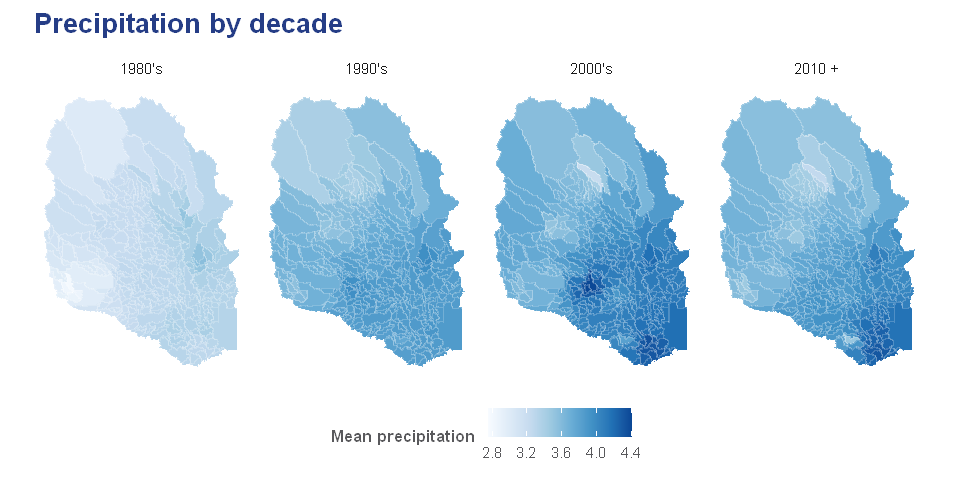

In [10]:
options(repr.plot.width=8, repr.plot.height=4)

ggplot() +
    geom_sf(data = sub_stats_sf, aes(fill = precip_avg), color = alpha("white", .2)) +
    coord_sf(datum = NA) +
    facet_grid(. ~ decade_lab) +
    scale_fill_gradientn(colours=(brewer.pal(8,"Blues"))) +
    theme(legend.position = "bottom") +
    labs(title = "Precipitation by decade", fill = "Mean precipitation")
    

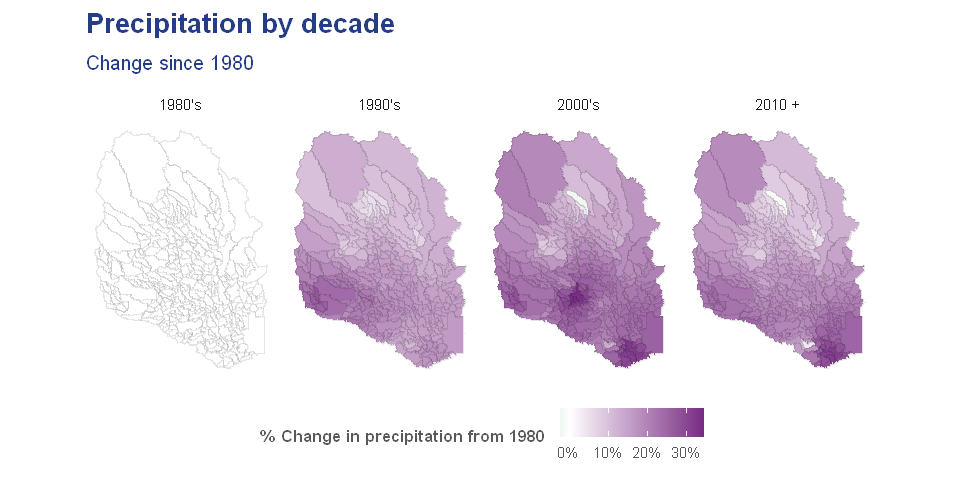

In [11]:
options(repr.plot.width=8, repr.plot.height=4)

ggplot() +
    geom_sf(data = sub_stats_sf, aes(fill = avg_change), color = alpha("black", .1)) +
    # geom_sf(data = sub_stats_sf %>% filter(avg_change > 0.25), fill = alpha("white", 0), color = alpha("red", .2)) +
    coord_sf(datum = NA) +
    facet_grid(. ~ decade_lab) +
    # scale_fill_gradientn(colours=rev((brewer.pal(8,"PRGn"))), limits = c(-0.5, 0.5), labels = scales::percent) +
    scale_fill_gradient2(low = "#1b7837", mid = "white", high = "#762a83", midpoint = 0, labels = scales::percent) +
    theme(legend.position = "bottom") +
    labs(title = "Precipitation by decade", subtitle = "Change since 1980", fill = "% Change in precipitation from 1980")
    

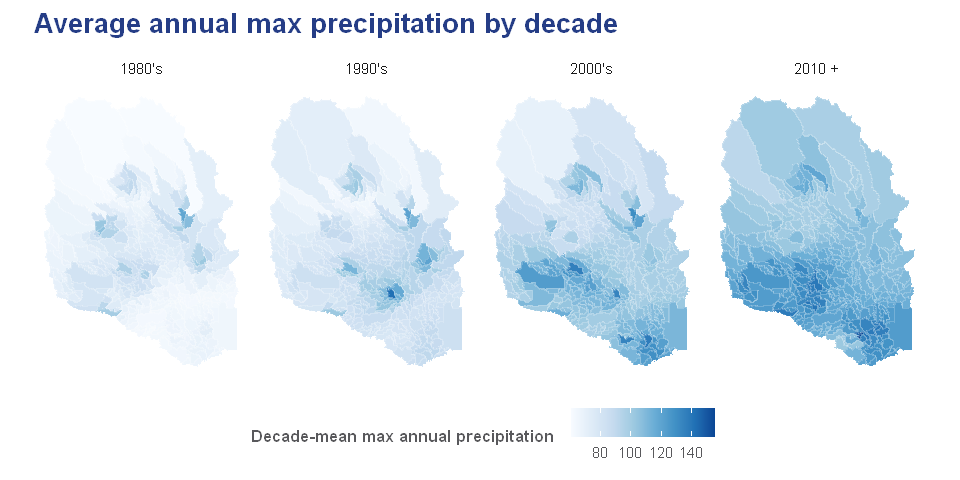

In [12]:
options(repr.plot.width=8, repr.plot.height=4)

ggplot() +
    geom_sf(data = sub_stats_sf, aes(fill = precip_max_avg), color = alpha("white", .2)) +
    coord_sf(datum = NA) +
    facet_grid(. ~ decade_lab) +
    scale_fill_gradientn(colours=(brewer.pal(8,"Blues"))) +
    theme(legend.position = "bottom") +
    labs(title = "Average annual max precipitation by decade", fill = "Decade-mean max annual precipitation")
    

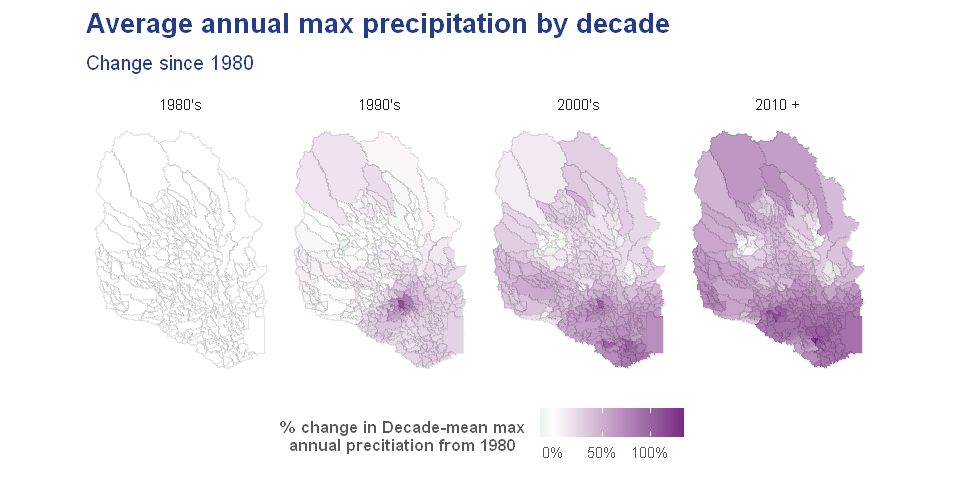

In [13]:
options(repr.plot.width=8, repr.plot.height=4)

ggplot() +
    geom_sf(data = sub_stats_sf, aes(fill = max_change), color = alpha("black", .1)) +
    # geom_sf(data = sub_stats_sf %>% filter(avg_change > 0.25), fill = alpha("white", 0), color = alpha("red", .2)) +
    coord_sf(datum = NA) +
    facet_grid(. ~ decade_lab) +
    # scale_fill_gradientn(colours=rev((brewer.pal(8,"PRGn"))), labels = scales::percent, limits = c(-1.5, 1.5)) +
    scale_fill_gradient2(low = "#1b7837", mid = "white", high = "#762a83", midpoint = 0, labels = scales::percent) +
    theme(legend.position = "bottom") +
    labs(title = "Average annual max precipitation by decade", subtitle = "Change since 1980", 
         fill = "% change in Decade-mean max\nannual precitiation from 1980")
    